In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, normalize

C:\Users\Erfan\anaconda3\envs\tf21gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import os
import numpy as np
import pandas as pd

X = []
y = []

base_dir = "eeg_csv_frames/"   # Main Root

for subject in os.listdir(base_dir):
    subject_dir = os.path.join(base_dir, subject, "Normalized")
    if not os.path.isdir(subject_dir):
        continue

    label = 1 if subject.lower().startswith("s") else 0

    for file in os.listdir(subject_dir):
        if "zscore_l2" in file and file.endswith(".csv"):
            file_path = os.path.join(subject_dir, file)
            df = pd.read_csv(file_path)
            X.append(df.to_numpy())
            y.append(label)

X = np.array(X)
y = np.array(y)

print("✅ Total Frames:", X.shape[0], "| Shape:", X.shape, "| Labels:", y.shape)


✅ Total Frames: 1142 | Shape: (1142, 6250, 19) | Labels: (1142,)


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
print(f"X_train shape is : {X_train.shape}")
print(f"X_val shape is : {X_val.shape}")
print("---------------------------------")
print(f"y_train shape is : {y_train.shape}")
print(f"y_val shape is : {y_val.shape}")

X_train shape is : (913, 6250, 19)
X_val shape is : (229, 6250, 19)
---------------------------------
y_train shape is : (913,)
y_val shape is : (229,)


In [5]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dropout, Dense, LSTM
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(6250, 19)),
    Conv1D(64, kernel_size=3, activation='relu'),
    Dropout(0.33),
    MaxPooling1D(pool_size=2),
    LSTM(100),
    Dropout(0.33),
    Dense(100),
    Dropout(0.20),
    Dense(50, activation='relu'),
    Dropout(0.20),
    Dense(1, activation='sigmoid')
])

In [6]:
# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6248, 64)          3712      
                                                                 
 conv1d_1 (Conv1D)           (None, 6246, 64)          12352     
                                                                 
 dropout (Dropout)           (None, 6246, 64)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3123, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                        

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

#  EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,              
    restore_best_weights=True, 
    verbose=1
)

#  Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,               
    batch_size=16,
    callbacks=[early_stop]
)


Epoch 1/50
58/58 [==============================] - 32s 315ms/step - loss: 0.6585 - accuracy: 0.5619 - val_loss: 0.5807 - val_accuracy: 0.6332
Epoch 2/50
58/58 [==============================] - 17s 299ms/step - loss: 0.5218 - accuracy: 0.7010 - val_loss: 0.5309 - val_accuracy: 0.6769
Epoch 3/50
58/58 [==============================] - 17s 294ms/step - loss: 0.4861 - accuracy: 0.7481 - val_loss: 0.5581 - val_accuracy: 0.7031
Epoch 4/50
58/58 [==============================] - 17s 291ms/step - loss: 0.4203 - accuracy: 0.7853 - val_loss: 0.4706 - val_accuracy: 0.7424
Epoch 5/50
58/58 [==============================] - 17s 299ms/step - loss: 0.4133 - accuracy: 0.8039 - val_loss: 0.4837 - val_accuracy: 0.7249
Epoch 6/50
58/58 [==============================] - 17s 301ms/step - loss: 0.4130 - accuracy: 0.8083 - val_loss: 0.4313 - val_accuracy: 0.7686
Epoch 7/50
58/58 [==============================] - 18s 308ms/step - loss: 0.3658 - accuracy: 0.8401 - val_loss: 0.4489 - val_accuracy: 0.7642

In [9]:
best_val_acc = max(history.history['val_accuracy'])
print(f"📈 Best Validation Accuracy: {best_val_acc:2f}")

📈 Best Validation Accuracy: 0.912664


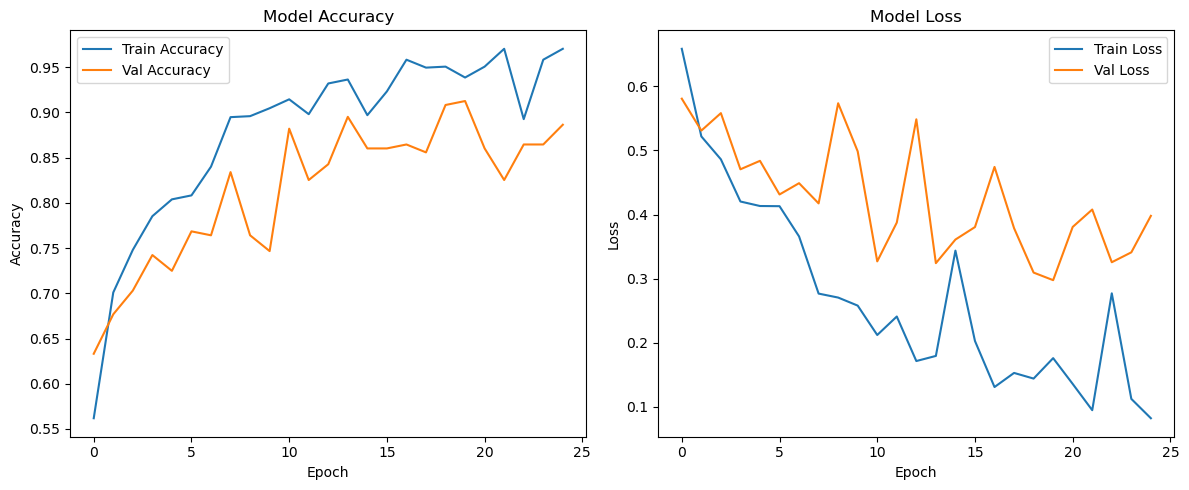

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"saved_model/h5/Training_chart_{str_acc}.png", dpi=300)
    plt.show()

plot_history(history)


In [11]:
# Prediction
y_pred_prob = model.predict(X_val).flatten()
y_pred_class = (y_pred_prob >= 0.5).astype(int)


8/8 [==============================] - 3s 201ms/step


In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# matrix
cm = confusion_matrix(y_val, y_pred_class)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-score
print("\nClassification Report:\n", classification_report(y_val, y_pred_class, digits=4))


Confusion Matrix:
 [[ 97   6]
 [ 14 112]]

Classification Report:
               precision    recall  f1-score   support

           0     0.8739    0.9417    0.9065       103
           1     0.9492    0.8889    0.9180       126

    accuracy                         0.9127       229
   macro avg     0.9115    0.9153    0.9123       229
weighted avg     0.9153    0.9127    0.9129       229



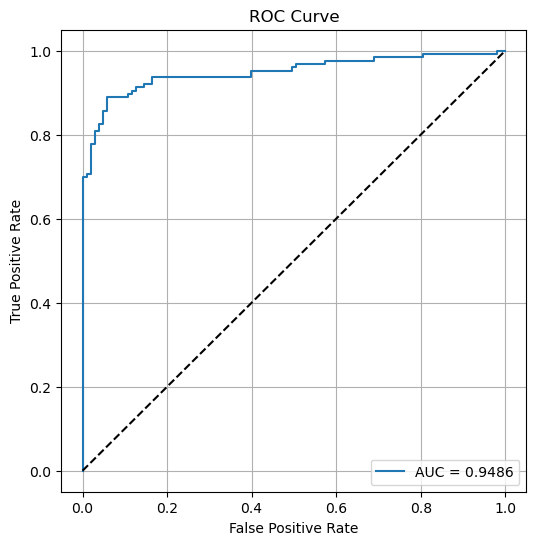

In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [14]:
str_acc = f"{best_val_acc:.2f}"
str_acc = str_acc[2:]

os.makedirs(f"saved_model/h5", exist_ok=True)

model.save(f"saved_model/h5/cnn_lstm_schizophrenia_{str_acc}.h5")

model.save(f"saved_model/cnn_lstm_schizophrenia_{str_acc}")


INFO:tensorflow:Assets written to: saved_model/cnn_lstm_schizophrenia_91\assets


INFO:tensorflow:Assets written to: saved_model/cnn_lstm_schizophrenia_91\assets
